<a href="https://colab.research.google.com/github/cdiegor/Simulacao/blob/main/Sistema_Reparos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Reparos N+S — Simulação em SimPy

Este caderno implementa um **sistema de reparos** com N máquinas em operação e S sobressalentes:
- Tempo até falha (quando operando): **Exponencial** com média \(1/\lambda\).
- Oficina de reparos: **1 servidor**, serviço **Normal**\((\mu,\sigma)\) truncada em \((0,\infty)\).
- Falha: troca imediata por uma reserva (se houver) e envio à **fila**.
- Pós-reparo: máquina retorna à reserva ou vai direto para a operação se \(< N\) operando.


## Parâmetros e métricas
- `N`, `S`, `lam`, `mu`, `sigma`, `T_max`, `seed`
- Métricas: disponibilidade média (e fração), fila média, utilização da oficina, eventos sem reserva; séries temporais para gráficos.


In [ ]:
!pip install simpy

In [ ]:
import numpy as np
import simpy
import math
import matplotlib.pyplot as plt

def make_rng(seed=None):
    return np.random.default_rng(seed)

def normal_trunc_pos(rng, mean, sd):
    while True:
        x = rng.normal(mean, sd)
        if x > 0:
            return float(x)


In [ ]:
class Maquina:
    def __init__(self, env, sistema, id_maquina, rng, lam):
        self.env = env; self.sis = sistema; self.id = id_maquina
        self.rng = rng; self.lam = float(lam)
        self.estado = "reserva"; self.proc = None

    def iniciar_operacao(self):
        self.estado = "operando"
        self.proc = self.env.process(self._operar())

    def _operar(self):
        ttf = self.rng.exponential(1.0 / self.lam)
        yield self.env.timeout(ttf)
        self.sis.on_falha(self)


In [ ]:
class SistemaReparos:
    def __init__(self, N, S, lam, mu, sigma, T_max, seed=None):
        self.env = simpy.Environment(); self.rng = make_rng(seed)
        self.N = int(N); self.S0 = int(S); self.lam = float(lam)
        self.mu = float(mu); self.sigma = float(sigma); self.T_max = float(T_max)

        self.oficina = simpy.Resource(self.env, capacity=1)
        self.fila_reparo = simpy.Store(self.env)

        self.operando = 0; self.reserva = []; self.ativas = set(); self.maquinas = []

        self._t_last = 0.0; self._area_operando = 0.0; self._area_fila = 0.0; self._ocupado = 0.0

        self.falhas = 0; self.reparos_concluidos = 0; self.eventos_sem_reserva = 0

        self.hist_t = [0.0]; self.hist_operando = [0]; self.hist_fila = [0]
        self.hist_reserva = [self.S0]; self.hist_oficina_busy = [0]

        for i in range(self.N + self.S0):
            self.maquinas.append(Maquina(self.env, self, i, self.rng, self.lam))

        for i in range(self.N):
            self._colocar_em_operacao(self.maquinas[i])
        for i in range(self.N, self.N + self.S0):
            self._colocar_na_reserva(self.maquinas[i])

        self.env.process(self._servidor_oficina())

    def _snap(self, oficina_busy):
        t = self.env.now; dt = t - self._t_last
        if dt > 0:
            self._area_operando += self.operando * dt
            self._area_fila += len(self.fila_reparo.items) * dt
            self._ocupado += (1 if oficina_busy else 0) * dt
            self._t_last = t
        self.hist_t.append(t)
        self.hist_operando.append(self.operando)
        self.hist_fila.append(len(self.fila_reparo.items))
        self.hist_reserva.append(len(self.reserva))
        self.hist_oficina_busy.append(1 if oficina_busy else 0)

    def _colocar_em_operacao(self, m):
        if m.estado == "operando": return
        self.operando += 1; self.ativas.add(m)
        if m in self.reserva: self.reserva.remove(m)
        m.iniciar_operacao()
        self._snap(oficina_busy=(self.oficina.count > 0))

    def _colocar_na_reserva(self, m):
        m.estado = "reserva"
        if m not in self.reserva: self.reserva.append(m)
        self._snap(oficina_busy=(self.oficina.count > 0))

    def on_falha(self, m):
        self.falhas += 1
        if m in self.ativas:
            self.ativas.remove(m); self.operando -= 1
        m.estado = "fila"; self.fila_reparo.put(m)
        if len(self.reserva) > 0:
            spare = self.reserva.pop()
            self._colocar_em_operacao(spare)
        else:
            self.eventos_sem_reserva += 1
            self._snap(oficina_busy=(self.oficina.count > 0))

    def _servidor_oficina(self):
        while True:
            m = (yield self.fila_reparo.get())
            with self.oficina.request() as req:
                yield req
                self._snap(oficina_busy=True)
                t_rep = normal_trunc_pos(self.rng, self.mu, self.sigma)
                yield self.env.timeout(t_rep)
                self.reparos_concluidos += 1
                if self.operando < self.N:
                    self._colocar_em_operacao(m)
                else:
                    self._colocar_na_reserva(m)
                self._snap(oficina_busy=False)

    def run(self):
        self.env.run(until=self.T_max)
        self._snap(oficina_busy=(self.oficina.count > 0))
        return self.resultados()

    def resultados(self):
        T = max(self.hist_t[-1], 1e-9)
        disp_media = self._area_operando / T
        frac_disp = disp_media / self.N
        fila_media = self._area_fila / T
        utiliz = self._ocupado / T
        return {"T": T, "falhas": self.falhas, "reparos_concluidos": self.reparos_concluidos,
                "operando_final": self.operando, "reserva_final": len(self.reserva),
                "eventos_sem_reserva": self.eventos_sem_reserva,
                "disp_media": disp_media, "frac_disponibilidade": frac_disp,
                "fila_media": fila_media, "utilizacao_oficina": utiliz,
                "hist_t": np.array(self.hist_t), "hist_operando": np.array(self.hist_operando),
                "hist_fila": np.array(self.hist_fila), "hist_reserva": np.array(self.hist_reserva),
                "hist_oficina_busy": np.array(self.hist_oficina_busy)}


## Execução única e gráficos


In [ ]:
params = dict(N=10, S=3, lam=0.05, mu=2.0, sigma=1.0, T_max=100.0, seed=2025)
sis = SistemaReparos(**params)
res = sis.run()

for k in ["falhas","reparos_concluidos","operando_final","reserva_final",
          "eventos_sem_reserva","disp_media","frac_disponibilidade",
          "fila_media","utilizacao_oficina"]:
    print(f"{k:>22s}: {res[k]}")


                falhas: 35
    reparos_concluidos: 34
        operando_final: 10
         reserva_final: 2
   eventos_sem_reserva: 10
            disp_media: 9.851581166542871
  frac_disponibilidade: 0.9851581166542871
            fila_media: 1.3830452968722715
    utilizacao_oficina: 0.7590729265695509


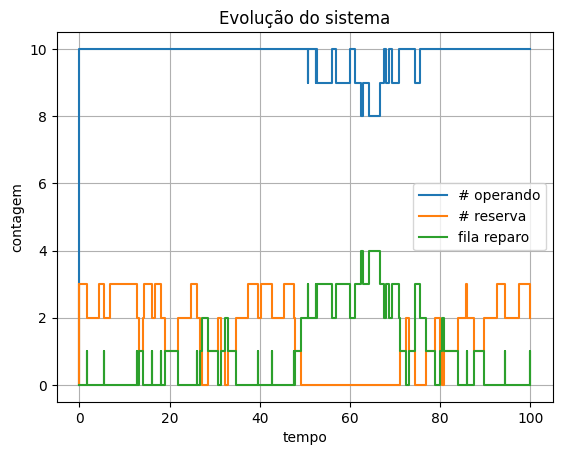

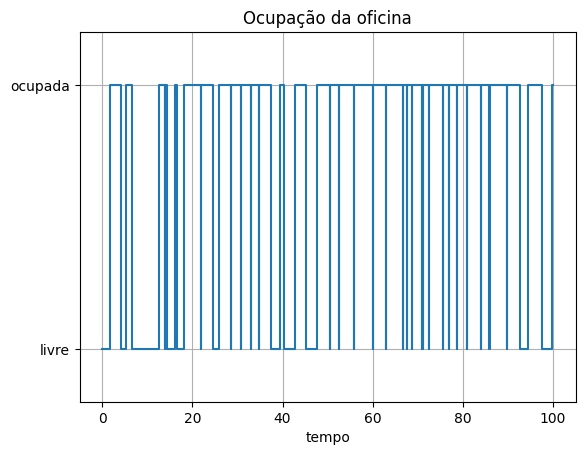

In [ ]:
t = res["hist_t"]

plt.figure()
plt.step(t, res["hist_operando"], where="post", label="# operando")
plt.step(t, res["hist_reserva"], where="post", label="# reserva")
plt.step(t, res["hist_fila"], where="post", label="fila reparo")
plt.xlabel("tempo"); plt.ylabel("contagem")
plt.title("Evolução do sistema")
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.step(t, res["hist_oficina_busy"], where="post")
plt.yticks([0,1], ["livre","ocupada"]); plt.ylim(-0.2, 1.2)
plt.xlabel("tempo"); plt.title("Ocupação da oficina")
plt.grid(True); plt.show()


## Replicações com ICs 95%


In [ ]:
def rodar_replicas(nrep=100, seed_base=1234, **kwargs):
    rng = make_rng(seed_base)
    disp = []; fila = []; util = []; esr = []
    for _ in range(nrep):
        seed = int(rng.integers(0, 2**63-1))
        sis = SistemaReparos(seed=seed, **kwargs)
        r = sis.run()
        disp.append(r["frac_disponibilidade"])
        fila.append(r["fila_media"])
        util.append(r["utilizacao_oficina"])
        esr.append(r["eventos_sem_reserva"])
    disp = np.array(disp); fila = np.array(fila); util = np.array(util); esr = np.array(esr)
    def mean_ci(x):
        m = x.mean(); s = x.std(ddof=1); n = x.size
        h = 1.96*s/np.sqrt(n) if n>1 else 0.0
        return m, (m-h, m+h)
    return {"disp_frac": mean_ci(disp),
            "fila_media": mean_ci(fila),
            "utilizacao": mean_ci(util),
            "eventos_sem_reserva": mean_ci(esr)}

ag = rodar_replicas(100, 2026, N=params["N"], S=params["S"],
                    lam=params["lam"], mu=params["mu"], sigma=params["sigma"],
                    T_max=params["T_max"])
ag


{'disp_frac': (np.float64(0.920998352047235),
  (np.float64(0.9081811108951501), np.float64(0.93381559319932))),
 'fila_media': (np.float64(2.524565684217878),
  (np.float64(2.326270902487957), np.float64(2.722860465947799))),
 'utilizacao': (np.float64(0.8608071959018241),
  (np.float64(0.8418430816204602), np.float64(0.879771310183188))),
 'eventos_sem_reserva': (np.float64(21.84),
  (np.float64(19.69297817957671), np.float64(23.98702182042329)))}